# Codenrock New Year ML Battle

## Imports and Config

In [1]:
# OS and fileworks
import os
import sys
import zipfile

# Imaging utils
import PIL

# Misc utils
from datetime import timedelta, datetime as dt
from time import time
import tqdm
import pycm

# Data processing
import numpy as np
import pandas as pd

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import (confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             classification_report)

# Tensorflow
import tensorflow as tf
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import Input, Model
from tensorflow.keras.models import load_model, Sequential
import tensorflow.keras.layers as L
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import (ModelCheckpoint, 
                                        EarlyStopping, 
                                        LearningRateScheduler,
                                        ReduceLROnPlateau)

from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications import (EfficientNetB0, EfficientNetB3, 
                                           EfficientNetB6, EfficientNetB7)
import albumentations as A

# Visualization
import matplotlib.pyplot as plt
plt.style.use('Solarize_Light2')
%matplotlib inline


print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Pandas       :', pd.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

Python       : 3.8.10 (default, Nov 26 2021, 20:14:08) 
Numpy        : 1.22.1
Pandas       : 1.4.2
Tensorflow   : 2.8.0
Keras        : 2.8.0


In [2]:
# Additional plotting tweaks
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10, 6)

# Enhance svg plots appearance
# %config InlineBackend.figure_format = 'svg'

In [3]:
# Save RANDOM_SEED and requirements
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
PYTHONHASHSEED = 0

!pip freeze > requirements.txt

In [4]:
# Define project directories
# DATA_DIR = '/storage/Codenrock New Year ML Battle/data/'
DATA_DIR = 'data/'
WORK_DIR = 'work/'

os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(WORK_DIR, exist_ok=True)

### Extract Dataset

In [5]:
import gdown

# train.csv
!gdown 1P8mRUt8kJXJHeMK_tRItm-OU_8wvNtGm --output $DATA_DIR
# train.zip
!gdown 1lcud8RU6o3C6FOpYpWjfHkSg9Sd1uTbi --output $DATA_DIR

Downloading...
From: https://drive.google.com/uc?id=1P8mRUt8kJXJHeMK_tRItm-OU_8wvNtGm
To: /notebooks/Codenrock New Year ML Battle/data/train.csv
100%|██████████████████████████████████████| 49.9k/49.9k [00:00<00:00, 49.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lcud8RU6o3C6FOpYpWjfHkSg9Sd1uTbi
To: /notebooks/Codenrock New Year ML Battle/data/train.zip
100%|████████████████████████████████████████| 340M/340M [00:14<00:00, 23.3MB/s]


In [6]:
def unpack_zip_files(zip_files, target_dir=None):
    for f in zip_files:
        print(f'Unpacking {f}.. ', end='')
        with zipfile.ZipFile(f, 'r') as z:
            z.extractall(target_dir)
    print('DONE')

In [7]:
%%time

unpack_zip_files([f'{DATA_DIR}/train.zip'], DATA_DIR)
print(os.listdir(DATA_DIR))

Unpacking data//train.zip.. DONE
['train', 'public.csv', 'train.zip', 'train.csv', 'test', 'test.zip']
CPU times: user 1.63 s, sys: 537 ms, total: 2.16 s
Wall time: 2min 32s


## Load Data

In [8]:
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_CSV = 'train.csv'

# Load the train data, immediately cutting off possible duplicates
df_train = pd.read_csv(os.path.join(DATA_DIR, TRAIN_CSV), 
                       sep='\t', dtype={'class_id': str})
df_train.drop_duplicates(inplace=True)

## EDA

In [9]:
df_train

,image_name,class_id
0,47bb5ccde11f47579620ebefbc93a021.jpg,0
1,b00af78e10694557a74f388ee03b2273.jpg,0
2,06a78176956b474aad83d62bc787412c.jpg,0
3,c941f6970e074b7684fa458a59401850.jpg,0
4,93c5a088369846bfba05d3408f0c555b.jpg,0
...,...,...
1275,902342a83a434ca99128bbe1e5e22827.jpg,2
1276,af220a007b2840c48eb3c4b4ed41c6bb.jpg,2
1277,22576ccb0847489c943a246a6fa6c0c9.jpg,2
1278,49431e763db64013baa9177bef357318.jpg,2


In [10]:
df_train.info()
print()
df_train['class_id'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1280 entries, 0 to 1279
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image_name  1280 non-null   object
 1   class_id    1280 non-null   object
dtypes: object(2)
memory usage: 30.0+ KB



0    800
1    240
2    240
Name: class_id, dtype: int64

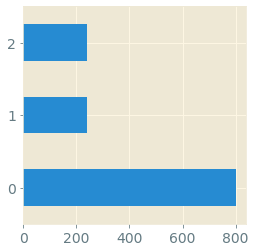

In [15]:
df_train['class_id'].value_counts().plot(kind='barh', figsize=(4, 4));

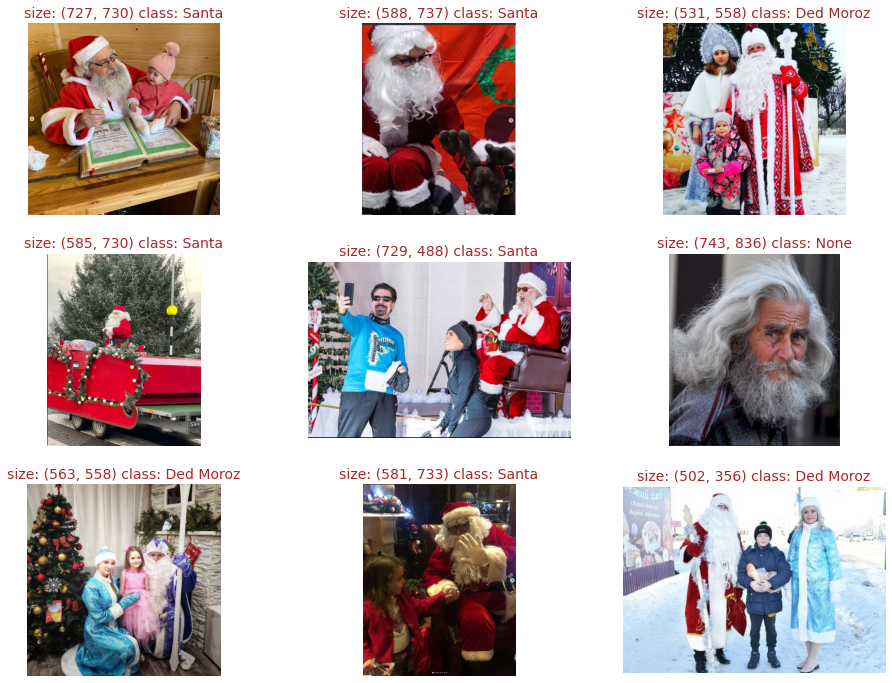

In [19]:
# Let's look at some image examples and show their sizes
# class_id == 0: Nobody
# class_id == 1: Ded Moroz is present
# class_id == 2: Santa is present
classes_dict = {'0': 'None', '1': 'Ded Moroz', '2': 'Santa'}

random_samples = df_train.sample(n=9)
random_samples = (zip(random_samples['image_name'].values, 
                      random_samples['class_id'].values))

plt.figure(figsize=(16, 12))
for i, (fname, class_id) in enumerate(random_samples):
    im = PIL.Image.open(os.path.join(TRAIN_DIR, fname))
    plt.subplot(3, 3, i + 1)
    plt.imshow(im)
    
    plt.title(f'size: {im.size} class: {classes_dict[class_id]}', 
              {'fontsize': 14, 'color': 'brown'})
    plt.axis('off')

In [14]:
# Now let's find out the average size of the images

files = df_train['image_name'].values

shapes = np.empty((0, 2), np.int32)
for f in files:
    im = PIL.Image.open(os.path.join(TRAIN_DIR, f))
    shapes = np.append(shapes, [im.size], axis=0)

# get average width and height among all the images
print('Average size if all images:')
print('mean: ', np.mean(shapes, axis=0, dtype=int))
print('median: ', np.median(shapes, axis=0))

Average size if all images:
mean:  [649 665]
median:  [641. 730.]


## Dataset Preparation

### Data Augmentation

In [15]:
# Create an image augmentation object
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5), 
    A.ShiftScaleRotate(shift_limit=0.20, scale_limit=0.20, 
                       rotate_limit=35, p=0.5), 
    A.OneOf([A.RandomBrightnessContrast(brightness_limit=0.25, 
                                        contrast_limit=0.25), 
             A.RandomBrightnessContrast(brightness_limit=0.1, 
                                        contrast_limit=0.1)], p=0.2), 
    A.RandomGamma(p=0.35), # 0.2 ?
    
    A.GaussNoise(p=0.6), # 0.15 ?    
    A.GaussianBlur(blur_limit=(5, 9), sigma_limit=(0.1, 5), p=0.5)
])

# Function to augment given images
def augment_image(image):
    aug_img = np.array(image)
    aug_img = augmentation(image=image)['image']
    return aug_img

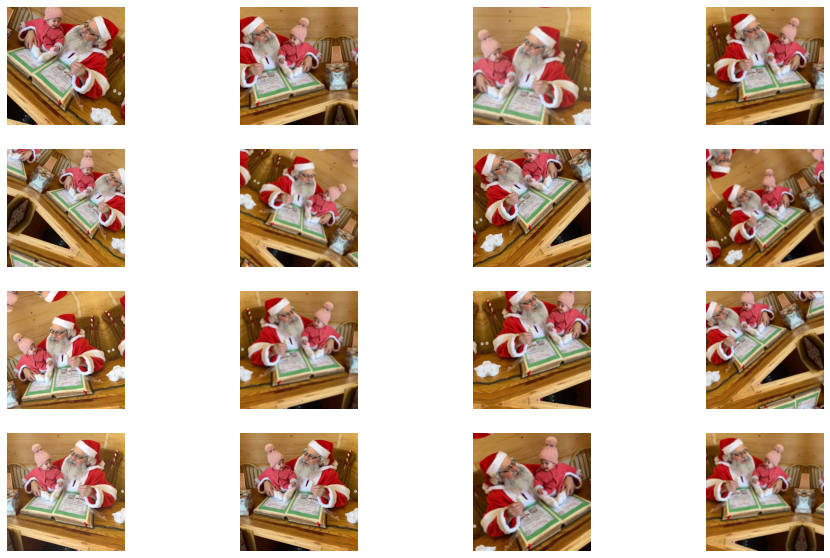

In [24]:
# Show random example of image augmentation

random_image = df_train.sample(random_state=RANDOM_SEED)
random_image = PIL.Image.open(
    os.path.join(TRAIN_DIR, random_image['image_name'].values[0])
)
random_image = np.array(random_image)

plt.figure(figsize=(16, 10))
for i in range(16):    
    im = augmentation(image=random_image)['image']

    plt.subplot(4, 4, i + 1)
    plt.imshow(im)
    plt.axis('off')
plt.show()

### Data Generators

In [17]:
def rebuild_generators(data, augment_func, target_size, batch_size, val_split, rescaling=True):
    if type(data) == pd.DataFrame:
        train_df, val_df = train_test_split(
            data, 
            test_size=val_split,
            random_state=RANDOM_SEED,
            stratify=data['class_id'].values
        )
        train_dir = val_dir = DATA_DIR + 'train/'
    else:
        train_df, val_df = data[:2]
        train_dir, val_dir = DATA_DIR + 'train/', DATA_DIR + 'test/'
    
    rescale = 1. / 255 if rescaling else None

#     train_datagen = ImageDataGenerator(
#         rescale=rescale, 
#         rotation_range=20, 
#         brightness_range=[0.5, 1.5], 
#         width_shift_range=0.1, 
#         height_shift_range=0.1, 
#         horizontal_flip=True
#     )
    train_datagen = ImageDataGenerator(preprocessing_function=augment_func, 
                                       rescale=rescale)
    val_datagen = ImageDataGenerator(rescale=rescale)
    
    # train set generator
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df, 
        directory=train_dir, 
        x_col='image_name', 
        y_col='class_id', 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=True, 
        seed=RANDOM_SEED
    )

    # validation set generator
    val_gen = val_datagen.flow_from_dataframe(
        dataframe=val_df, 
        directory=val_dir, 
        x_col='image_name', 
        y_col='class_id', 
        target_size=target_size, 
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False
    ) 
    return train_gen, val_gen

## Model

### Helper Functions

In [18]:
def plot_history(history):
    '''Plots history of a trained model'''
    # F1-Score
    plt.plot(history.history['f1_score'])
    plt.plot(history.history['val_f1_score'])
    plt.title('F1-Score', color='firebrick')
    plt.ylabel('f1_score')
    plt.xlabel('epoch')
    plt.legend(['f1 train', 'f1 validation'], loc='upper left')
    plt.show()

    # Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss', color='firebrick')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['loss train', 'loss validation'], loc='upper left')
    plt.show()

In [19]:
def scheduler(epoch, lr, start=10):
    '''Defines scheduler for LearningRateScheduler'''
    if epoch < start:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def recreate_callbacks(es_patience=10, use_scheduler=True, scheduler_start=10, 
                       checkpoint_name='best_model.h5', best_only=True):
    '''Makes a list with new instances of each tensorflow callback'''
    
    callbacks_list = [ModelCheckpoint(os.path.join(WORK_DIR, checkpoint_name), 
                                      monitor='val_f1_score', 
                                      mode='max', 
                                      save_best_only=best_only, 
                                      save_weights_only=True, 
                                      verbose=0), 
                      EarlyStopping(monitor='val_f1_score', 
                                    mode='max', 
                                    patience=es_patience, 
                                    restore_best_weights=True, 
                                    verbose=1)]
    if use_scheduler:
        callbacks_list.append(
            LearningRateScheduler(lambda ep, lr: 
                                  scheduler(ep, lr, scheduler_start), 
                                  verbose=1)
        )
    return callbacks_list

### Hyperparameters and Generators


In [85]:
IMG_SIZE     = 384     # input image size
BATCH_SIZE   = 8       # batch size
VAL_SPLIT    = 0.10    # validation set portion
LR           = 0.0001  # learning rate

# build data generators with image augmentation
train_gen, val_gen = rebuild_generators(df_train, 
                                        augment_image, 
                                        target_size=(IMG_SIZE, IMG_SIZE), 
                                        batch_size=BATCH_SIZE, 
                                        val_split=VAL_SPLIT,
                                        rescaling=False)

Found 2160 validated image filenames belonging to 3 classes.
Found 240 validated image filenames belonging to 3 classes.


## Model Assembly

In [21]:
# !pip install -U keras-efficientnet-v2

import keras_efficientnet_v2 as efn_v2

In [22]:
def pretrained_assemble(base, head, name=None):
    output = base.output
    
    for layer in head.layers:
        output = layer(output)

    return Model(inputs=base.input, 
                 outputs=output, 
                 name=name)

In [23]:
def classification_model(input_shape, num_classes=3):
#     base_model = EfficientNetB3(include_top=False, 
#                                 weights='imagenet', 
#                                 input_shape=input_shape
#                                 )

    base_model = efn_v2.EfficientNetV2S(num_classes=0, 
                                        pretrained='imagenet', 
                                        include_preprocessing=True, 
                                        input_shape=input_shape
                                        )
    
    head = Sequential([
        L.GlobalAveragePooling2D(), 
        L.Dense(1792, use_bias=True, kernel_regularizer='l2'), 
        L.Dropout(0.5), 
        L.Activation('selu'), 
        L.Dense(896, use_bias=True, kernel_regularizer='l2'), 
        L.Dropout(0.5), 
        L.Activation('selu'), 
        L.Dense(448, use_bias=True, kernel_regularizer='l2'), 
        L.Dropout(0.5), 
        L.Activation('selu'), 
        L.Dense(224, use_bias=True, kernel_regularizer='l2'), 
        L.Dropout(0.5), 
        L.Activation('selu'), 
        L.Dense(num_classes, activation='softmax')
    ])
    
    name = f'{base_model.name}_{input_shape[0]}x{input_shape[1]}'
    return pretrained_assemble(base_model, head, name)

In [24]:
model = classification_model(input_shape=(IMG_SIZE, IMG_SIZE, 3))

model.compile(loss='categorical_crossentropy', 
              optimizer=optimizers.Adam(learning_rate=LR, amsgrad=True), 
              metrics=['accuracy', F1Score(num_classes=3, average='weighted')]
              )

model.summary()

87859200/87846816 [==============================] - 4s 0us/step
>>>> Load pretrained from: /root/.keras/models/efficientnetv2/efficientnetv2-s-imagenet.h5
Model: "EfficientNetV2S_384x384"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 384, 384, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 384, 384, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 192, 192, 24  648         ['rescaling[0][0]']              
                   

## Fit

In [93]:
%%time
# default head-256 (from datagens)

history = model.fit(train_gen, 
                    validation_data=val_gen, 
                    batch_size=8, #BATCH_SIZE, 
                    epochs=20, #15, 
                    callbacks=recreate_callbacks(es_patience=15, scheduler_start=10), 
                    verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/20
270/270 [==============================] - 85s 239ms/step - loss: 36.1663 - accuracy: 0.3912 - f1_score: 0.3911 - val_loss: 34.0113 - val_accuracy: 0.6500 - val_f1_score: 0.5589 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/20
270/270 [==============================] - 62s 229ms/step - loss: 33.0129 - accuracy: 0.4690 - f1_score: 0.4681 - val_loss: 30.6458 - val_accuracy: 0.8917 - val_f1_score: 0.8884 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/20
270/270 [==============================] - 62s 228ms/step - loss: 29.8328 - accuracy: 0.5245 - f1_score: 0.5241 - val_loss: 27.4623 - val_accuracy: 0.9125 - val_f1_score: 0.9114 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/20
270/270 [==============================] - 62s 231m

In [94]:
model.load_weights(WORK_DIR + 'best_model.h5')
model.evaluate(val_gen, verbose=1, return_dict=True)

30/30 [==============================] - 2s 64ms/step - loss: 8.7057 - accuracy: 1.0000 - f1_score: 1.0000


{'loss': 8.705706596374512, 'accuracy': 1.0, 'f1_score': 1.0}

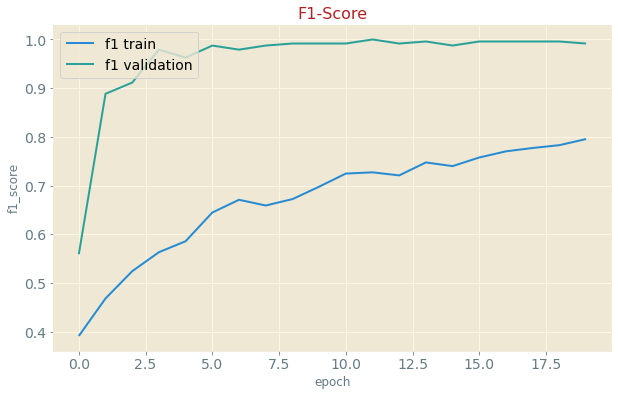

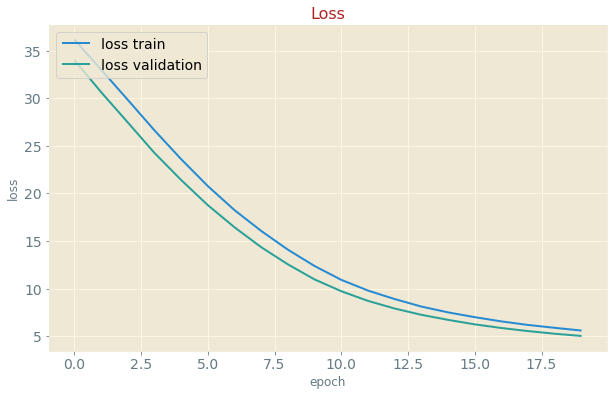

In [95]:
plot_history(history)

In [96]:
y_pred = model.predict(val_gen)
y_pred = np.argmax(y_pred, axis=1)

y_true = np.array(val_gen.labels)

In [97]:
print(classification_report(y_true, y_pred, target_names=['0', '1', '2']))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        80
           1       1.00      1.00      1.00        80
           2       1.00      1.00      1.00        80

    accuracy                           1.00       240
   macro avg       1.00      1.00      1.00       240
weighted avg       1.00      1.00      1.00       240



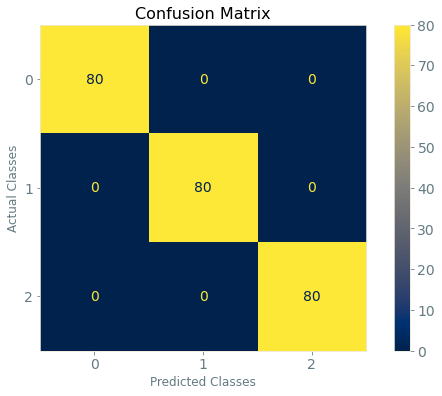

In [98]:
# Multi-class classification confusion matrix
cm = pycm.ConfusionMatrix(y_true, y_pred)

cm.plot(cmap=plt.cm.cividis, number_label=True, plot_lib='matplotlib')
plt.grid(visible=False)

### Save model

In [28]:
model.load_weights(WORK_DIR + 'best_model.h5')
model.evaluate(val_gen, verbose=1)

8/8 [==============================] - 1s 127ms/step - loss: 1.5210 - accuracy: 1.0000 - f1_score: 1.0000


[1.5210273265838623, 1.0, 1.0]

In [29]:
model.save(WORK_DIR + 'model.h5', 
           include_optimizer=False)

## Submission

In [ ]:
TEST_DIR = os.path.join(DATA_DIR, 'test')

# Build test data generator from given directory
test_df = pd.DataFrame(os.listdir(TEST_DIR), columns=['image_name'])

test_datagen = ImageDataGenerator(rescale=rescale)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df, 
    directory=test_dir, 
    x_col='image_name',
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)
dataset.build_test_generator(TEST_DIR)

# Load pretrained model for inference
# model = load_model(f'{WORK_DIR}/best_model.h5')

y_pred = model.predict(dataset.test_gen)
y_pred = np.argmax(y_pred, axis=1)


# SUBMISSION
submission = dataset.test_df.copy()
submission['class_id'] = y_pred
submission.to_csv(os.path.join(WORK_DIR, 'submission.csv'), 
                  index=False, sep='\t')